In [ ]:
!pip install shap

In [ ]:
!pip install optuna

In [30]:
## import packages
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.formula.api as smf
import statsmodels.api as sm

import shap
import optuna

from utils import model

from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
## load data by locations
sj_train_features = pd.read_csv("Data/ProcessedData/sj_train_features.csv")
sj_train_labels = pd.read_csv("Data/ProcessedData/sj_train_labels.csv")
sj_validation_features = pd.read_csv("Data/ProcessedData/sj_validation_features.csv")
sj_validation_labels = pd.read_csv("Data/ProcessedData/sj_validation_labels.csv")

iq_train_features = pd.read_csv("Data/ProcessedData/iq_train_features.csv")
iq_train_labels = pd.read_csv("Data/ProcessedData/iq_train_labels.csv")
iq_validation_features = pd.read_csv("Data/ProcessedData/iq_validation_features.csv")
iq_validation_labels = pd.read_csv("Data/ProcessedData/iq_validation_labels.csv")

In [5]:
## drop city col
sj_train_features.drop(columns=['city'], inplace=True)
sj_validation_features.drop(columns=['city'], inplace=True)
iq_train_features.drop(columns=['city'], inplace=True)
iq_validation_features.drop(columns=['city'], inplace=True)

In [6]:
## tranform target value
sj_train_labels = np.log1p(sj_train_labels)
iq_train_labels = np.log1p(iq_train_labels)

#### LightGBM

##### Hyperparameter Tuning

In [ ]:
## SJ model
best_lgb_sj, lgb_parameters_sj, study_sj = model.lgb_model(sj_train_features, sj_train_labels, sj_validation_features,
                                                     sj_validation_labels, seed=42, n_trials=150)

In [ ]:
## IQ model
best_lgb_iq, lgb_parameters_iq, study_iq = model.lgb_model(iq_train_features, iq_train_labels, iq_validation_features,
                                                     iq_validation_labels, seed=42, n_trials=150)

##### Validation data

In [19]:
## MAE for validation data
mean_absolute_error(np.expm1(pd.concat([pd.DataFrame(best_lgb_sj.predict(sj_validation_features)),
                                        pd.DataFrame(best_lgb_iq.predict(iq_validation_features))])),
                    pd.concat([sj_validation_labels, iq_validation_labels]))

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.72, subsample=1.0 will be ignored. Current value: bagging_fraction=0.72
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0.06999999999999999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


12.247033284062995

##### Feature Importance Analysis

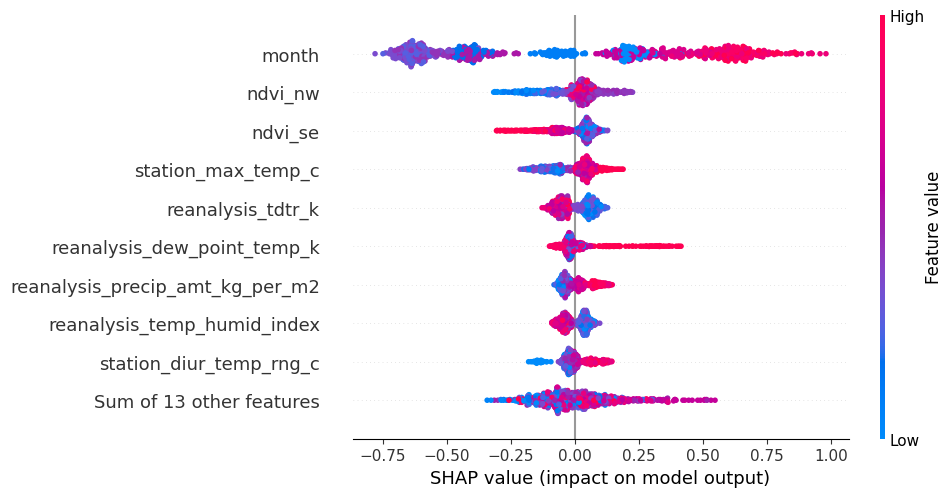

In [25]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_lgb_sj)
shap_values = explainer(sj_train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

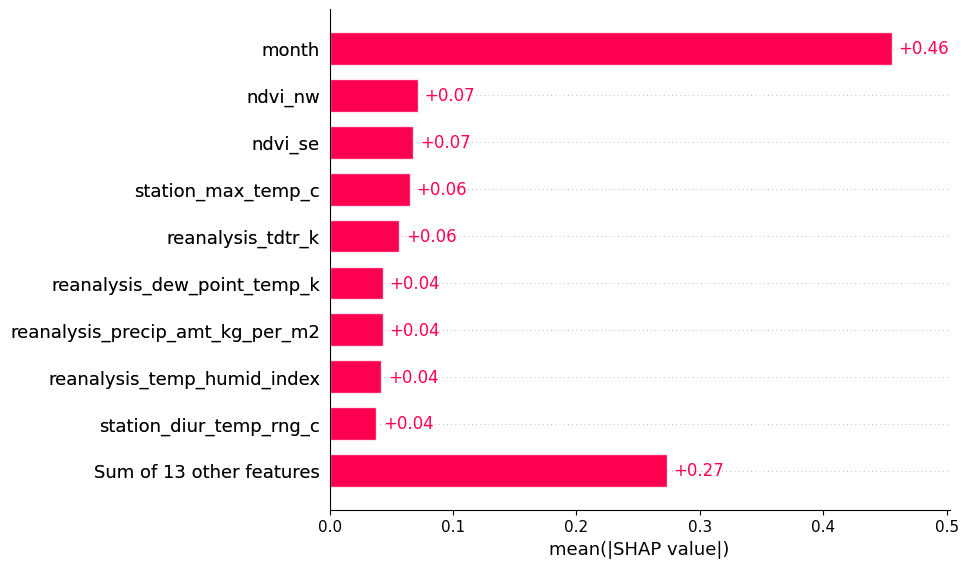

In [21]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

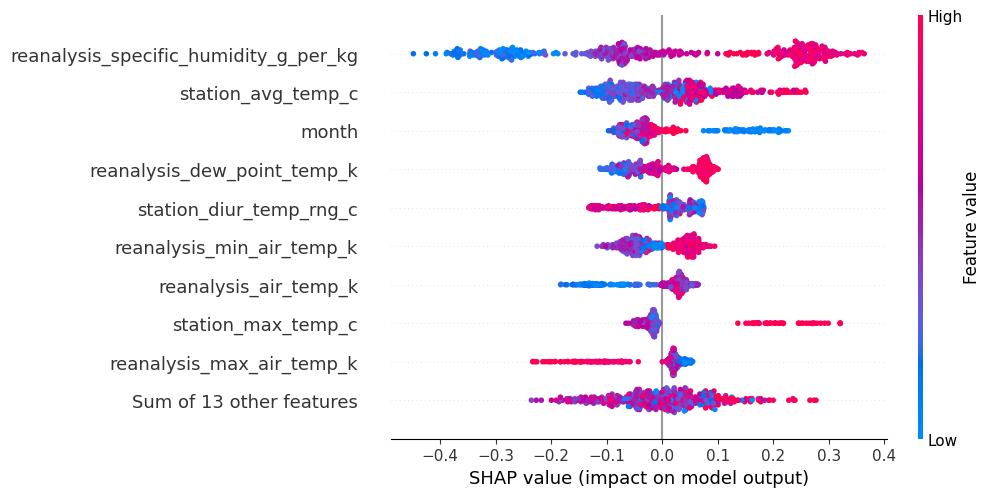

In [22]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(best_lgb_iq)
shap_values = explainer(iq_train_features)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

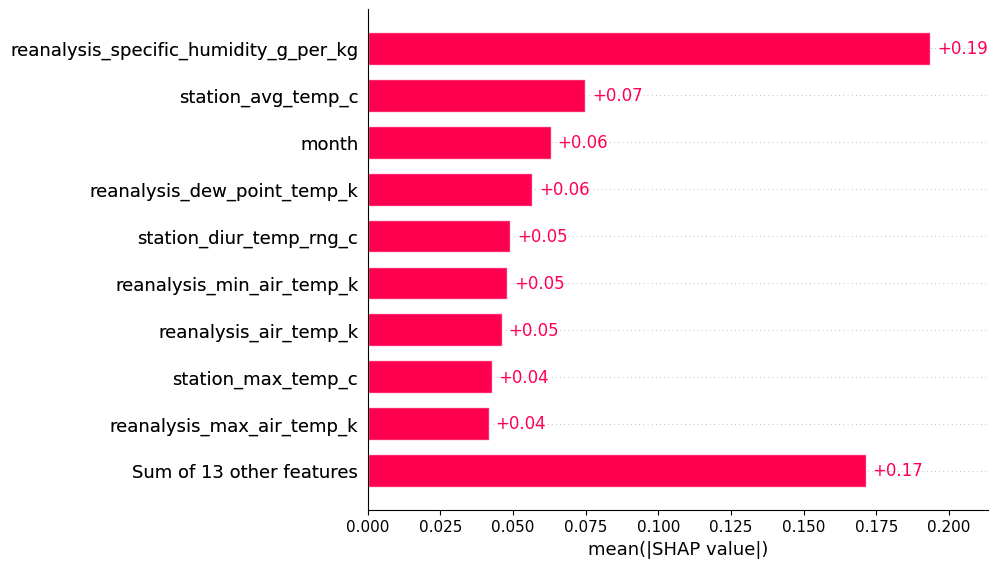

In [23]:
## SHAP importance for LightGBM
shap.plots.bar(shap_values)

#### XGBoost

##### Hyperparameter Tuning

In [ ]:
## SJ model
best_xgb_sj, xgb_parameters_sj, study_sj = model.xgb_model(sj_train_features, sj_train_labels, sj_validation_features,
                                                     sj_validation_labels, seed=42, n_trials=150)

In [ ]:
## IQ model
best_xgb_iq, xgb_parameters_iq, study_iq = model.xgb_model(iq_train_features, iq_train_labels, iq_validation_features,
                                                     iq_validation_labels, seed=42, n_trials=150)

##### Validation data

In [28]:
## MAE for validation data
mean_absolute_error(np.expm1(pd.concat([pd.DataFrame(best_xgb_sj.predict(sj_validation_features)),
                                        pd.DataFrame(best_xgb_iq.predict(iq_validation_features))])),
                    pd.concat([sj_validation_labels, iq_validation_labels]))

13.867477329626475

####Negative Binomial Regression

In [37]:
## SJ
formula = ' + '.join([str(i) for i in list(sj_train_features.columns)])
formula = 'y ~ ' + formula

train_sj = sj_train_features.copy()
train_sj['y'] = sj_train_labels
test_sj = sj_validation_features.copy()

NBR_sj = smf.glm(formula=formula,
                data=train_sj,
                family=sm.families.NegativeBinomial())
NBR_sj = NBR_sj.fit()

prds_sj = NBR_sj.predict(test_sj).astype(int)
print ("MAE:", mean_absolute_error(prds_sj, sj_validation_labels))

MAE: 24.03191489361702


In [38]:
## IQ
formula = ' + '.join([str(i) for i in list(iq_train_features.columns)])
formula = 'y ~ ' + formula

train_iq = iq_train_features.copy()
train_iq['y'] = iq_train_labels
test_iq = iq_validation_features.copy()

NBR_iq = smf.glm(formula=formula,
                data=train_sj,
                family=sm.families.NegativeBinomial())
NBR_iq = NBR_iq.fit()

prds_iq = NBR_iq.predict(test_iq).astype(int)
print ("MAE:", mean_absolute_error(prds_iq, iq_validation_labels))

MAE: 3.9615384615384617


In [39]:
## Single MAE
pred = prds_sj.append(prds_iq)
true = sj_validation_labels.append(iq_validation_labels)
print ("MAE:", mean_absolute_error(pred, true))

MAE: 16.883561643835616
